# Walker Example

In [1]:
import sys
sys.path.append('lib')

import numpy as np
import matplotlib.pyplot as plt
import os, time

from IPython.core import display

import pybullet as p
import pybullet_data
from scipy.optimize import fmin_bfgs
from functools import partial

from pb_utils.kine import get_joint_limits, check_joint_limits
from pb_utils.visualize import set_q, vis_traj, create_primitives
from pb_utils.transform import mat2euler, mat2w
from pin_utils.pin_utils import computeJacobian, computePose

from residuals import ResidualFrameTranslationFloatingBase, ResidualFrameRotationSE3FloatingBase, ResidualBound, \
                        ResidualPosture, ResidualSum, ResidualStructure, CostProjector, clip_bounds
from motion_planning import sampler, talos_sampler, col_checker, interpolator, cRRT

import pinocchio as pin

from walker_config import q0Complete, q0CompleteCabinet, q0CompleteDrawer
from walker_config import T_drawer, T_cabinet

from residuals import ResidualFrameSE3FloatingBase, ResidualBoundFloatingBase, \
    ResidualCOMBounds, ResidualPosture, ResidualSum, CostProjector
import transforms3d
DATA_PATH = '/home/teguh/git/rli/learning_distribution_gan/tf_robot_learning/data'

%load_ext autoreload
%autoreload 2
%matplotlib inline



### Setup Pybullet

In [2]:
physics_client_id = p.connect(p.GUI)

p.setPhysicsEngineParameter(enableFileCaching=0)
p.setAdditionalSearchPath(pybullet_data.getDataPath())
p.configureDebugVisualizer(p.COV_ENABLE_GUI,0)

In [3]:
p.resetSimulation()

#### Load in pybullet

In [4]:
#load robot
robot_urdf = DATA_PATH + '/urdf/walker_description/urdf/walker_simple.urdf';
robot_id = p.loadURDF(fileName=robot_urdf, flags=p.URDF_USE_SELF_COLLISION_EXCLUDE_PARENT, )
dof = p.getNumJoints(robot_id)

#load plane
plane_id = p.loadURDF('plane.urdf')
# p.resetBasePositionAndOrientation(plane_id, (0,0,0), np.array([0,0,0,1]))

#### Load obstacles

In [5]:
shelf_urdf = '/home/teguh/git/rli/learning_distribution_gan/tf_robot_learning/data/urdf/shelf_new.urdf'
shelf_id = p.loadURDF(shelf_urdf)

In [6]:
p.resetBasePositionAndOrientation(shelf_id,(.7,0.8,0), (0,0,np.sin(np.pi/2), np.cos(np.pi/2)) )
p.resetBasePositionAndOrientation(shelf_id,(.7,-0.5,0), (0,0,np.sin(np.pi/2), np.cos(np.pi/2)) )
# p.resetJointState(shelf_id, 7, 0.4)

#### Create cabinet & can

In [7]:
_,_,can_id = create_primitives(p.GEOM_CYLINDER, radius=0.033, length = 0.122)
angle = 0
pos_can = np.array([0.22,-0.5,0.66+0.066])
p.resetBasePositionAndOrientation(can_id, pos_can, (np.sin(angle/2),0,0,np.cos(angle/2)))

_,_,cabinet_id = create_primitives(p.GEOM_BOX, halfExtents=[0.205, 0.27,  0.33])
p.resetBasePositionAndOrientation(cabinet_id, (0.1,-0.7,0.33), (0,0,0,1))

#### Define frame indices

In [8]:
pb_frame_names = [p.getJointInfo(robot_id,i)[1].decode('UTF-8') for i in range(dof)]
pb_lh_frame_id = pb_frame_names.index('left_tcp_joint')
pb_rh_frame_id = pb_frame_names.index('right_tcp_joint')
pb_lf_frame_id = pb_frame_names.index('left_sole')
pb_rf_frame_id = pb_frame_names.index('right_sole')

#### Load from pinocchio

In [9]:
rmodel = pin.buildModelFromUrdf(robot_urdf , pin.JointModelFreeFlyer())
rdata = rmodel.createData()
rdata = rmodel.createData()

robot_joint_limits = np.vstack([rmodel.lowerPositionLimit, rmodel.upperPositionLimit])
for i in range(robot_joint_limits.shape[0]):
    for j in range(robot_joint_limits.shape[1]):
        if robot_joint_limits[i,j] < -1e10: robot_joint_limits[i,j] = -1e10
        if robot_joint_limits[i,j] > 1e10: robot_joint_limits[i,j] = 1e10

pin_frame_names = [f.name for f in rmodel.frames]
lh_frame_id = rmodel.getFrameId('left_tcp_joint')
rh_frame_id = rmodel.getFrameId('right_tcp_joint')
lf_frame_id = rmodel.getFrameId('left_sole')
rf_frame_id = rmodel.getFrameId('right_sole')

pin_joint_names = []
for i,f in enumerate(rmodel.names): 
    pin_joint_names.append(f)

pb_joint_indices = []
pb_joint_indices_names = []
for pin_name in pin_joint_names[2:]:
    pb_joint_indices.append(pb_frame_names.index(pin_name))
    pb_joint_indices_names.append(pin_name)

pb_joint_indices = np.array(pb_joint_indices)

In [10]:
#set default visualization function
set_q_std = partial(set_q,robot_id=robot_id, joint_indices=pb_joint_indices, set_base=True)
set_q_std(q0Complete)
vis_traj_std = partial(vis_traj, vis_func = set_q_std)

#### Define target poses

In [11]:
#left foot
pos_lf, ori_lf = computePose(rmodel,rdata,lf_frame_id,q0Complete)
rpy_lf = mat2euler(ori_lf)
pose_lf_ref = np.concatenate([pos_lf, rpy_lf])
#right foot
pos_rf, ori_rf = computePose(rmodel,rdata,rf_frame_id,q0Complete)
rpy_rf = mat2euler(ori_rf)
pose_rf_ref = np.concatenate([pos_rf, rpy_rf])
#left hand
pos_lh, ori_lh = computePose(rmodel,rdata,lh_frame_id,q0Complete)
pose_lh_ref = np.concatenate([np.array([0.3,0.2, 0.4]), np.array([0,-np.pi/2,0.])])
#right hand
pos_rh, ori_rh = computePose(rmodel,rdata,rh_frame_id,q0Complete)
rpy_rh = mat2euler(ori_rh)
pose_rh_ref = np.concatenate([pos_rh, rpy_rh])

#### Visualize in Pybullet

### Define projector & IK solver

#### Define target poses

In [12]:
#left foot
w_lf = mat2w(ori_lf)
pose_lf_ref = pin.SE3(ori_lf, pos_lf)
#right foot
w_rf = mat2w(ori_rf)
pose_rf_ref = pin.SE3(ori_rf, pos_rf)
#right hand
w_rh = mat2w(ori_rh)
# pose_rh_ref = pos_rh
pose_rh_ref = pin.SE3(ori_rh, pos_rh)
pose_rh_ref.rotation = np.array([
    [0, -1, 0],
    [0,0,-1],
    [1, 0, 0]
]) #the hand in position to grasp a can from side


pose_lh_ref = pin.SE3(ori_lh, pos_lh)
pose_lh_ref.rotation = np.array([
    [0, 1, 0],
    [0,0,1],
    [1, 0, 0]
]) #the hand in position to grasp a can from side

#### Define projector & ik solver

In [13]:
lf_cost = ResidualFrameSE3FloatingBase(rmodel, rdata, pose_lf_ref,lf_frame_id, weight=np.array([1.,1.,1.,1.,1.,1.]))
rf_cost = ResidualFrameSE3FloatingBase(rmodel, rdata, pose_rf_ref,rf_frame_id, weight=np.array([1.,1.,1.,1.,1.,1.]))
# rh_cost = ResidualFrameTranslationFloatingBase(rmodel, rdata, pose_rh_ref,rh_frame_id, weight=np.array([1.,1.,1.]))
rh_cost = ResidualFrameSE3FloatingBase(rmodel, rdata, pose_rh_ref,rh_frame_id, weight=np.array([1.,1.,1.,0.,1.,1.]))
rh_cost_project = ResidualFrameSE3FloatingBase(rmodel, rdata, pose_rh_ref,rh_frame_id, weight=np.array([0,0,0.,1.,1.,1.]))

lh_cost = ResidualFrameSE3FloatingBase(rmodel, rdata, pose_lh_ref,lh_frame_id, weight=np.array([1.,1.,1.,0.,1.,1.]))
lh_cost_project = ResidualFrameSE3FloatingBase(rmodel, rdata, pose_lh_ref,lh_frame_id, weight=np.array([0,0,0.,1.,1.,1.]))

# rh_cost = ResidualFrameSE3FloatingBase(rmodel, rdata, pose_rh_ref_new,rh_frame_id, weight=np.array([1.,1.,1.,.1,0.1,.1]))
# com_bounds = np.array([[-0.05,-0.05,0.4],[0.05, 0.05, 0.7]]) #prev
# com_bounds = np.array([[-0.02,-0.05,0.5],[0.02, 0.05, 0.6]]) #new
com_bounds = np.array([[-0.05,-0.05,0.65],[0.05, 0.05, 0.75]]) #new, with the updated urdf


cost_com_bounds = ResidualCOMBounds(rmodel, rdata, com_bounds, 1e-4)
bound_cost = ResidualBoundFloatingBase(robot_joint_limits, 1e-4)
posture_weights = np.ones(len(pb_joint_indices)+6) 
# posture_weights[3:6] *= 1000
posture_cost = ResidualPosture(rmodel, rdata, q0Complete, weights = posture_weights)

In [14]:
#cost function for projection
cost_sum = ResidualSum(rmodel, rdata, ignore_indices=[0,1,2,3,4,5,   6, 7, 8, 9, 10, 11, 19, 20, 21, 22, 23, 24])
cost_sum.addCost(lf_cost, 20., 'lf_pose', 1e-4)
cost_sum.addCost(rf_cost, 20.,'rf_pose', 1e-4)
cost_sum.addCost(rh_cost_project, 20.,'rh_pose_project', 1e-4)
cost_sum.addCost(cost_com_bounds, 100., 'com_limit', 1e-3)
cost_sum.addCost(bound_cost, 20., 'joint_limit', 1e-3)

#secondary task: posture regularization
cost_sum2 = ResidualSum(rmodel, rdata)
cost_sum2.addCost(posture_cost, 1. , 'posture', 1e3)

robot_projector = CostProjector(cost_sum, rmodel, rdata, cost2 = cost_sum2, bounds = robot_joint_limits)

In [15]:
#cost function for IK
cost_sum_ik = ResidualSum(rmodel, rdata, ignore_indices=[0,1,2,3,4,5,   6, 7, 8, 9, 10, 11, 19, 20, 21, 22, 23, 24])
cost_sum_ik.addCost(lf_cost, 20., 'lf_pose', 1e-4)
cost_sum_ik.addCost(rf_cost, 20.,'rf_pose', 1e-4)
cost_sum_ik.addCost(cost_com_bounds, 20., 'com_limit', 1e-3)
cost_sum_ik.addCost(bound_cost, 20., 'joint_limit', 1e-3)
cost_sum_ik.addCost(rh_cost, 20.,'rh_pose', 1e-3)


cost_sum3 = ResidualSum(rmodel, rdata)
cost_sum3.addCost(posture_cost, 1. , 'posture', 1e3)

robot_ik_solver = CostProjector(cost_sum_ik, rmodel, rdata,cost2 = cost_sum3,  bounds = robot_joint_limits)

#### Define the sampler

In [16]:
ignore_indices=[0,1,2,3,4,5,6,    7, 8, 9, 10, 11,12,   13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]

In [17]:
#define standard sampler
base_bound = com_bounds.copy()
base_bound[:,-1] = np.array([1, 1.1])
base_sampler = sampler(base_bound.copy())
joint_sampler = sampler(robot_joint_limits[:,7:])
rob_sampler = talos_sampler(base_sampler, np.array([0,0,0,1]), joint_sampler,  ignore_indices, q0Complete)

#### Try sampler

In [18]:
q = rob_sampler.sample()[0]
set_q_std(q)

#### Try the projector

In [19]:
set_q_std(q0Complete)

In [32]:
q = rob_sampler.sample().flatten()
res = robot_projector.project(q)
set_q_std(q)
input()
set_q_std(res['q'])

KeyboardInterrupt: Interrupted by user

### Try the IK solver

In [21]:
def get_ik_solution(desired_pos, solver, rob_sampler, which_hand='rh_pose'):
    status = False
    while status == False:
        solver.cost.costs[which_hand].cost.desired_pose.translation = desired_pos

        q = rob_sampler.sample().flatten()
        set_q_std(q)
        res = solver.project(q)
        set_q_std(res['q'])
        status = res['stat']
    return res['q']

In [22]:
pos_des = np.array([0.5, -0.2, 0.95])
q_des = get_ik_solution(pos_des, robot_ik_solver, rob_sampler)

## c-RRT with Talos

In [23]:
col_ids = [shelf_id, cabinet_id, can_id]
rob_col_checker = col_checker(robot_id, pb_joint_indices, col_ids, omit_indices=[ 50, 57], floating_base = True) #omit the collision of the plane with the feet
rob_interpolator = interpolator()
rrt = cRRT(rmodel.nq, rob_sampler, rob_col_checker, rob_interpolator, robot_projector)

#### Get the initial and target config

In [24]:
pos_init = np.array([0.18, -0.5, 0.726+0.15])
pos_init_can = np.array([0.18, -0.5, 0.726+0.1])
pos_goals = np.array([
    [0.4, 0., 1.],
#     [0.4, -0.1, 1.],
    [0.4, -0.2, 1.],
#     [0.4, -0.3, 1.],
    [0.4, -0.4, 1.],
    
#     [0.45, -0.1, 1.],
#     [0.45, -0.2, 1.],
#     [0.45, -0.3, 1.],
#     [0.45, -0.4, 1.],

    [0.5, -0.2, 1.],
#     [0.5, -0.3, 1.],
    [0.5, -0.4, 1.],
])

In [25]:
q_init = get_ik_solution(pos_init,  robot_ik_solver, rob_sampler)
q_can = get_ik_solution(pos_init_can,  robot_ik_solver, rob_sampler)

In [26]:
q_goals = []
q_goal_tables= []
for pos_goal in pos_goals:
    print(pos_goal)
    q_goal = get_ik_solution(pos_goal, robot_ik_solver, rob_sampler)
    pos_goal_table = np.copy(pos_goal)
    pos_goal_table[2] -= 0.1
    q_goal_table = get_ik_solution(pos_goal_table, robot_ik_solver, rob_sampler)

    q_goals.append(q_goal)
    q_goal_tables.append(q_goal_table)

[0.4 0.  1. ]
[ 0.4 -0.2  1. ]
[ 0.4 -0.4  1. ]
[ 0.5 -0.2  1. ]
[ 0.5 -0.4  1. ]


### Plan using cRRT

#### Plan1

In [27]:
rh_cost_project.weight = np.array([0,0,0,0,0,0])

traj1, nfevs, nexts, success, retry, t, path1 = rrt.plan(q0Complete, [q_init], max_extension_steps=500)

Solution is found!
Solution found!


In [28]:
short_path1 = rrt.shortcut_path(path1)

short_traj1 = rrt.interpolate_traj(short_path1, step_length = 0.02)

In [29]:
vis_traj_std(short_traj1, dt = 0.01)

#### Plan 2

In [30]:
rrt.samples = [q_init, q_can]

traj2 = rrt.interpolate_traj([0,1], step_length=0.02)

In [31]:
vis_traj_std(traj2)

#### Plan 3-4

In [35]:
rh_cost_project.weight = np.array([0,0,0,0,1,1])

traj3_set = []
traj4_set = []
for q_goal, q_goal_table in zip(q_goals, q_goal_tables):
    traj3, nfevs, nexts, success, retry, t, path3 = rrt.plan(q_can, [q_goal], max_extension_steps=500)
    short_path3 = rrt.shortcut_path(path3)
    short_traj3 = rrt.interpolate_traj(short_path3, step_length = 0.02)
    traj3_set.append(short_traj3)
    
    rrt.samples = [np.copy(q_goal), np.copy(q_goal_table)]
    traj4 = rrt.interpolate_traj([0,1], step_length=0.02)
    traj4_set.append(traj4)

Solution is found!
Solution found!
Solution is found!
Solution found!
Solution is found!
Solution found!
Solution is found!
Solution found!
Solution is found!
Solution found!


In [38]:
idx = 1
vis_traj_std(traj3_set[idx], dt = 0.01)
vis_traj_std(traj4_set[idx], dt = 0.01)

#### Concatenate

In [169]:
traj_set = []
i = 0
for traj3, traj4 in zip(traj3_set, traj4_set):
    traj = np.concatenate([short_traj1, traj2, traj3, traj4])
    traj_set.append(traj)

In [198]:
data = dict()
data['trajs'] = traj_set
data['joint_names'] = pb_joint_indices_names
data['grasp_time'] = len(short_traj1) + len(traj2)
np.save('data/traj_10ms.npy', data)

In [211]:
data = np.load('data/for_zhipeng/traj_10ms.npy', allow_pickle=True)[()]
trajs = data['trajs']

### Part 2: Handover task

In [282]:
#cost function for projection
cost_sum_left = ResidualSum(rmodel, rdata, ignore_indices=[0,1,2,3,4,5,   6, 7, 8, 9, 10, 11, 19, 20, 21, 22, 23, 24])
cost_sum_left.addCost(lf_cost, 20., 'lf_pose', 1e-4)
cost_sum_left.addCost(rf_cost, 20.,'rf_pose', 1e-4)
cost_sum_left.addCost(lh_cost_project, 20.,'lh_pose_project', 1e-4)
cost_sum_left.addCost(cost_com_bounds, 100., 'com_limit', 1e-3)
cost_sum_left.addCost(bound_cost, 20., 'joint_limit', 1e-3)

#secondary task: posture regularization
cost_sum_left2 = ResidualSum(rmodel, rdata)
cost_sum_left2.addCost(posture_cost, 1. , 'posture', 1e3)

robot_projector_left = CostProjector(cost_sum_left, rmodel, rdata, cost2 = cost_sum_left2, bounds = robot_joint_limits)

In [283]:
#cost function for IK
cost_sum_ik_left = ResidualSum(rmodel, rdata, ignore_indices=[0,1,2,3,4,5,   6, 7, 8, 9, 10, 11, 19, 20, 21, 22, 23, 24])
cost_sum_ik_left.addCost(lf_cost, 20., 'lf_pose', 1e-4)
cost_sum_ik_left.addCost(rf_cost, 20.,'rf_pose', 1e-4)
cost_sum_ik_left.addCost(cost_com_bounds, 20., 'com_limit', 1e-3)
cost_sum_ik_left.addCost(bound_cost, 20., 'joint_limit', 1e-3)
cost_sum_ik_left.addCost(lh_cost, 20.,'lh_pose', 1e-3)


cost_sum_ik_left3 = ResidualSum(rmodel, rdata)
cost_sum_ik_left3.addCost(posture_cost, 1. , 'posture', 1e3)

robot_ik_solver_left = CostProjector(cost_sum_ik_left, rmodel, rdata,cost2 = cost_sum_ik_left3,  bounds = robot_joint_limits)

In [284]:
ignore_indices_left=[0,1,2,3,4,5,6,    7, 8, 9, 10, 11,12,   20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]

In [325]:
#define standard sampler
rob_sampler_left = talos_sampler(base_sampler, np.array([0,0,0,1]), joint_sampler,  ignore_indices_left, q0Complete)
rob_sampler_left.q_ref = np.copy(q_goals[0])

In [338]:
q = rob_sampler_left.sample().flatten()
res = robot_projector_left.project(q)
set_q_std(res['q'])

#### Get configs

#### Step 1

In [360]:
pos_init_left = np.copy(pos_goals[0])
pos_init_left[2] -= 0.12
pos_init_left[1] += 0.05

In [361]:
q_init_left = get_ik_solution(pos_init_left, robot_ik_solver_left, rob_sampler_left, 'lh_pose')

#### Step 2

In [347]:
pos_goal_left2_set = np.array([[0.5, 0.3, 1],
                          [0.45, 0.4, 1.], 
                          [0.5, 0.2, 1.]])
q_goals_left = []
q_goals_table_left = []
for pos_goal_left2 in pos_goal_left2_set:
    q = get_ik_solution(pos_goal_left2, robot_ik_solver_left, rob_sampler_left, 'lh_pose')
    q_goals_left.append(np.copy(q))
    
    pos_goal_left2_table = np.copy(pos_goal_left2)
    pos_goal_left2_table[2]-= 0.1
    q = get_ik_solution(pos_goal_left2_table, robot_ik_solver_left, rob_sampler_left, 'lh_pose')
    q_goals_table_left.append(np.copy(q))

### Plan RRT

In [497]:
_,_,cyl_id = create_primitives(p.GEOM_CYLINDER, radius = 0.025, length=0.3, rgbaColor=[0.7, 0.1, 0.,0.8])

p.resetBasePositionAndOrientation(cyl_id,(0.405, 0.02, 1.) , (0,0,0,1))

In [388]:
col_ids_left = [shelf_id, cabinet_id, can_id, cyl_id]
rob_col_checker_left = col_checker(robot_id, pb_joint_indices, col_ids_left, omit_indices=[ 50, 57], floating_base = True) #omit the collision of the plane with the feet

rrt_left = cRRT(rmodel.nq, rob_sampler_left, rob_col_checker, rob_interpolator, robot_projector_left)

#### Step 1

In [411]:
lh_cost_project.weight = np.array([0,0,0,0,0,0])

traj_left1, nfevs, nexts, success, retry, t, path_left1 = rrt_left.plan(q_goals[0], [q_init_left], max_extension_steps=500)

In [414]:
short_path_left1 = rrt_left.shortcut_path(path_left1)

short_traj_left1 = rrt_left.interpolate_traj(short_path_left1, step_length = 0.02)

In [412]:
vis_traj_std(traj_left1, dt = 0.1)

In [415]:
vis_traj_std(short_traj_left1, dt = 0.01)

#### Step 2

In [417]:
lh_cost_project.weight = np.array([0,0,0,0,1,1])

In [438]:
traj2_set_left = []
traj3_set_left = []
for q_goal, q_goal_table in zip(q_goals_left, q_goals_table_left):
    traj_left_2, nfevs, nexts, success, retry, t, path_left2 = rrt_left.plan(q_init_left, [q_goal], max_extension_steps=500)
    short_path_left2 = rrt_left.shortcut_path(path_left2)
    short_traj_left2 = rrt_left.interpolate_traj(short_path_left2, step_length = 0.02)
    traj2_set_left.append(short_traj_left2)
    
    rrt_left.samples = [np.copy(q_goal), np.copy(q_goal_table)]
    traj_left_3 = rrt_left.interpolate_traj([0,1], step_length=0.02)
    traj3_set_left.append(traj_left_3)

Solution is found!
Solution found!
Solution is found!
Solution found!
Solution is found!
Solution found!


#### Concatenate

In [452]:
#combine the three first phase in right hand movement
# traj_left_init = traj_set[0][:-64]
#combine simply
traj_left_init = np.concatenate([short_traj1, traj2, traj3_set[0]])

# vis_traj_std(traj_left_init, dt = 0.01)

#combine with pause
traj_set_left = []
i = 0
for traj2, traj3 in zip(traj2_set_left, traj3_set_left):
    traj = np.concatenate([short_traj1, np.tile(traj2[0], (20,1)), traj2, np.tile(traj3[0], (20,1)), traj3])
    traj_set_left.append(traj)

In [457]:
vis_traj_std(traj_set[0], dt = 0.02)

#### Concatenate fully (with pause)

In [503]:
traj_left_set_full = []
for i in range(3):
    p.resetBasePositionAndOrientation(cyl_id, pos_can, (0,0,0,1))
    vis_traj_std(traj_left_init[:192], dt = 0.02)
    stop1 = np.tile(traj_left_init[192],(20,1))
    time.sleep(0.5)
    vis_traj_spec(traj_left_init[192:], rh_frame_id, dt = 0.02)
    time.sleep(0.5)
    vis_traj_std(traj_set_left[i][:204], dt = 0.02)
    stop2 = np.tile(traj_set_left[0][204],(20,1))
    time.sleep(0.5)
    vis_traj_spec(traj_set_left[i][204:], lh_frame_id, offset=0.1, dt = 0.02)
    time.sleep(1.5)
    traj = np.concatenate([traj_left_init[:192],stop1, traj_left_init[192:],
                          traj_set_left[i][:204], stop2, traj_set_left[i][204:] ])
    traj_left_set_full.append(traj)

#### Visualization

In [473]:
def vis_traj_spec(traj, frame_id, offset = 0., dt = 0.01):
    for q in traj:
        set_q_std(q)
        pos,_ = computePose(rmodel, rdata, frame_id, q)
        pos[2] += offset
        p.resetBasePositionAndOrientation(cyl_id, pos, (0,0,0,1))
        time.sleep(dt)

In [518]:
data = dict()
data['trajs'] = traj_left_set_full
data['joint_names'] = pb_joint_indices_names
data['grasp_time_right'] = 192
data['grasp_time_left'] = 593
np.save('data/traj_10ms_handover.npy', data)

In [521]:
data = np.load('data/traj_10ms_handover.npy', allow_pickle=True)[()]
trajs = data['trajs']

In [522]:
len(traj_left_init) + 204

573

In [523]:
vis_traj_std(trajs[0], dt=0.01)

In [514]:
vis_traj_std(trajs[0][:192], dt=0.01)

In [517]:
vis_traj_std(trajs[0][:593], dt=0.01)

In [516]:
vis_traj_std(trajs[0][593:], dt=0.01)

# Check step by step

In [185]:
selected_rrt = rrt

#### Select task

In [186]:
i = 0
start_state = q0CompleteCabinet
goal_states = goal_configs[0]

In [190]:
set_q_std(start_state)

In [191]:
set_q_std(goal_states[0])

In [384]:
selected_rrt.init_plan(start_state,goal_states)

#### Pick random sample

In [451]:
selected_rrt.random_sample, nfev = selected_rrt.sample(False)
selected_rrt.random_sample = selected_rrt.random_sample.flatten()

In [452]:
set_q_std(selected_rrt.random_sample)

#### Find the nearest neighbor

In [453]:
nearest_index, nearest_sample = selected_rrt.find_nearest(selected_rrt.random_sample, np.array(selected_rrt.samples))

In [454]:
set_q_std(nearest_sample.flatten())

#### Extend to the random sample

In [455]:
selected_rrt.next_states, nfev = selected_rrt.extend(nearest_index[0], nearest_sample.flatten(), selected_rrt.random_sample.flatten(), max_increments=40)
q_reach_a = rrt.next_states[-1]

In [456]:
set_q_std(nearest_sample.flatten())

In [457]:
vis_traj_std(selected_rrt.next_states)

In [458]:
set_q_std(selected_rrt.random_sample)

#### Find the nearest goal

In [459]:
nearest_index, nearest_sample = selected_rrt.find_nearest(q_reach_a, np.array(selected_rrt.goal_state))
q_goal = nearest_sample.flatten()
set_q_std(q_goal)

#### Extend to the nearest goal

In [460]:
selected_rrt.next_states_goal, nfev = selected_rrt.extend(len(selected_rrt.samples) - 1, selected_rrt.next_states[-1], q_goal, max_increments=100)

In [461]:
set_q_std(q_reach_a.flatten())

In [462]:
vis_traj_std(selected_rrt.next_states_goal)

In [463]:
set_q_std(selected_rrt.next_states_goal[-1])

In [432]:
set_q_std(q_goal)

In [464]:
set_q_std(q0Complete)

In [495]:
q_mod = q0Complete.copy()

In [500]:
q_mod[7+9] = 1

In [501]:
set_q_std(q_mod)

(array([ 2.,  2.,  2., 18.,  8.,  7.,  6.,  7.,  0.,  3.]),
 array([-1.118 , -0.823 , -0.528 , -0.233 ,  0.062 ,  0.357 ,  0.652 ,
         0.947 ,  1.242 ,  1.537 ,  1.8321]),
 <BarContainer object of 10 artists>)

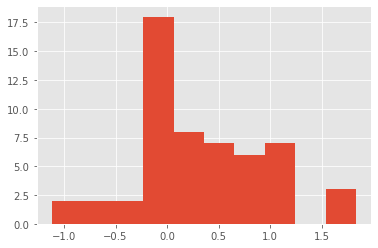

In [504]:
plt.hist(pb_data[11])

## Check Self Collision

In [165]:
def check_collision(robot_id, object_ids, omit_indices=[-1], verbose=True):
    print('ChecK')
    p.performCollisionDetection()
    self_collision = False
    collision = False
    conts = p.getContactPoints(robot_id, robot_id)
    # contact distance, positive for separation, negative for penetration
    if len(conts) >= 1:
        for cont in conts:
            distance = cont[8]
            if distance < 1e-3: # if smaller than 1 mm
                if verbose:
                    print("Robot's ", link_names[cont[3]], " is in contact with the link ",
                  link_names[cont[4]], "with a contact distance of ", distance)
                self_collision = True

            if self_collision: 
                print(self_collision)
                return self_collision or collision, None
                
    if not self_collision:
        for object_id in object_ids:
            conts = p.getContactPoints(robot_id, object_id)
            if len(conts) >= 1:
                for cont in conts:
                    if cont[8] < 1e-3:
                        collision = True
                        print(self_collision, object_id)
                        return self_collision or collision, None
    return self_collision or collision, None